# Keras/TensorflowでMNISTデータセットの画像分類

### 0. ライブラリのインポート

In [1]:
import os
import pathlib

import numpy as np
import pandas as pd 
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print("numpy :", np.__version__)
print("pandas :", pd.__version__)
print("tensorflow :", tf.__version__)
print("matplotlib :", matplotlib.__version__)

numpy : 1.16.1
pandas : 0.24.2
tensorflow : 1.13.1
matplotlib : 3.0.2


### 1. 実行環境についての設定

モデルの学習曲線(後述)を描画できるように,CSVファイルを作成しましょう．

In [3]:
CSV_FILE_PATH = "trainlog.csv"
if not os.path.exists(CSV_FILE_PATH): 
    pathlib.Path(CSV_FILE_PATH).touch()

### 2. データセットの読み込み

Tensorflowから実行環境(このファイル)へMNIST Datasetを読み込みましょう．

---

MNIST Dataset:
- trainデータ
  - X_train: 手書き数字の白黒画像 60,000枚 -  ${\left\{ {\bf x}_i \in \mathbb{R}^{28 \times 28} \right\}}_{i=1 \sim 60000}$
  - y_train: 手書き数字のラベル 60,000個 - ${\left\{ y_i \in [0,1,\dots,9] \right\}}_{i=1 \sim 60000}$
- testデータ
  - X_test: 手書き数字の白黒画像 10,000枚 -  ${\left\{ {\bf x}_i \in \mathbb{R}^{28 \times 28} \right\}}_{i=1 \sim 10000}$
  - y_test: 手書き数字のラベル 10,000個 - ${\left\{ y_i \in [0,1,\dots,9] \right\}}_{i=1 \sim 10000}$

In [4]:
# Load MNIST dataset from tensorflow
mnist = tf.keras.datasets.mnist
(X_train, y_train),(X_test, y_test) = mnist.load_data()
del mnist

In [5]:
print("X_train : ", X_train.shape)
print("y_train : ", y_train.shape)
print("X_test : ", X_test.shape)
print("y_test : ", y_test.shape)

X_train :  (60000, 28, 28)
y_train :  (60000,)
X_test :  (10000, 28, 28)
y_test :  (10000,)


**MNIST Datasetのサンプル**

X(白黒画像)とy(ラベル)を見てみましょう．

y_train (i=1):  0
X_train (i=1): 


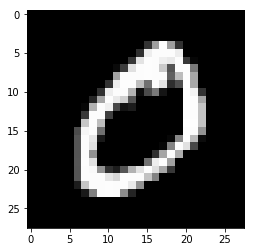

y_train (i=10):  3
X_train (i=10): 


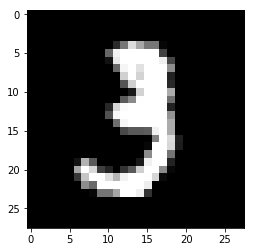

y_train (i=100):  5
X_train (i=100): 


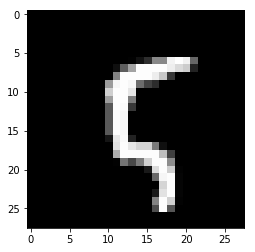

In [6]:
 for i in [1,10,100]:
    print("y_train", "(i="+str(i)+"): ", y_train[i])
    print("X_train", "(i="+str(i)+"): ")    
    plt.imshow(X_train[i], cmap='gray')
    plt.show()

### 3. 画像データの正規化

一般に，「(扱う)データの値を，何らかの基準に基づいて整える」処理を正規化(Normalization, Scalijng)といいます．代表的な正規化手法としては以下2つが挙げられます．

1. min-max normalization
   - 最小値が0, 最大値が1になるように変換する
   - x_new = (x - x_min) / (x_max - x_min)
2. z-score normalization
   - 平均が0, 標準偏差が1になるよう変換する
   - x_new = (x - x_mean) / x_std

MNIST Datasetに含まれる画像データでは，各画素の値が「0以上255以下」の8bit整数で表現されています．今回は，これにmin-max normalizationを適用することで，値の範囲を「0~1」に限定させます．

In [7]:
print("X_train min", X_train.min())
print("X_train max", X_train.max())

X_train min 0
X_train max 255


In [8]:
# Min-Max Normalization
X_train, X_test = X_train/255.0, X_test/255.0

In [9]:
print("X_train min", X_train.min())
print("X_train max", X_train.max())

X_train min 0.0
X_train max 1.0


### 4. モデルの作成

In [10]:
# モデル
model = tf.keras.models.Sequential([
    # (None, 28, 28) -> (None, 784)
    tf.keras.layers.Flatten(input_shape=(28, 28), name='input'),
    
    # Layer1: Linear mapping: (None, 784) -> (None, 512)
    tf.keras.layers.Dense(512, name='fc_1'),
    # Activation function: ReLU
    tf.keras.layers.Activation(tf.nn.relu, name='relu_1'),
    
    # Layer2: Linear mapping: (None, 512) -> (None, 256)
    tf.keras.layers.Dense(256, name='fc_2'),
    # Activation function: ReLU
    tf.keras.layers.Activation(tf.nn.relu, name='relu_2'),
    
    # Layer3: Linear mapping: (None, 256) -> (None, 256)
    tf.keras.layers.Dense(256, name='fc_3'),
    # Activation function: ReLU
    tf.keras.layers.Activation(tf.nn.relu, name='relu_3'),
    
    # Layer4: Linear mapping: (None, 256) -> (None, 10)
    tf.keras.layers.Dense(10, name='dense_3'),
    # Activation function: Softmax
    tf.keras.layers.Activation(tf.nn.softmax, name='softmax')
])

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
# View model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 784)               0         
_________________________________________________________________
fc_1 (Dense)                 (None, 512)               401920    
_________________________________________________________________
relu_1 (Activation)          (None, 512)               0         
_________________________________________________________________
fc_2 (Dense)                 (None, 256)               131328    
_________________________________________________________________
relu_2 (Activation)          (None, 256)               0         
_________________________________________________________________
fc_3 (Dense)                 (None, 256)               65792     
_________________________________________________________________
relu_3 (Activation)          (None, 256)               0         
__________

In [12]:
# Compiling
# Set model & training information into machine memory (CPU or GPU)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# Set callback functions which are called during model training
callbacks = []
callbacks.append(tf.keras.callbacks.CSVLogger(CSV_FILE_PATH))

### 5. モデルの学習

モデルにtrainデータを与えて，学習(training)させましょう．

- train データ (`X_train`, `y_train`): 
   - モデル(`model`)の学習(training)に用いる．
- test データ (`X_test`, `y_test`): 
   - モデル(`model`)の性能検証(validation)に用いる．

> ```python
> # Train model
> history = model.fit(...)
> ```

なお，ニューラルネットワーク$f_{\theta}: X \mapsto Y$において，「推論」「学習」とは以下の計算処理を指します．

- 推論(inference)とは 
   - 順伝播(input x → output y)によって，モデルの出力値$y$を計算すること
   - $(X,\theta)$は固定値，$y$に着目
- 学習(training)とは
   - 逆伝播(output y → input x)によって，モデルのパラメータ$\theta$を更新すること
   - $(X,y)$は固定値，$\theta$に着目

In [14]:
# Train model
history = model.fit(X_train, y_train, 
                    batch_size=100, 
                    epochs=30,
                    verbose=1, 
                    validation_data=(X_test, y_test),
                    callbacks=callbacks)

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 9s 144us/sample - loss: 0.2194 - acc: 0.9344 - val_loss: 0.0950 - val_acc: 0.9695
Epoch 2/30
60000/60000 [==============================] - 7s 124us/sample - loss: 0.0826 - acc: 0.9749 - val_loss: 0.0940 - val_acc: 0.9715
Epoch 3/30
60000/60000 [==============================] - 7s 118us/sample - loss: 0.0561 - acc: 0.9821 - val_loss: 0.0742 - val_acc: 0.9762
Epoch 4/30
60000/60000 [==============================] - 6s 99us/sample - loss: 0.0403 - acc: 0.9872 - val_loss: 0.0875 - val_acc: 0.9739
Epoch 5/30
60000/60000 [==============================] - 6s 100us/sample - loss: 0.0321 - acc: 0.9901 - val_loss: 0.0760 - val_acc: 0.9794
Epoch 6/30
60000/60000 [==============================] - 7s 122us/sample - loss: 0.0282 - acc: 0.9907 - val_loss: 0.0832 - val_acc: 0.9771
Epoch 7/30
60000/60000 [==============================] - 9s 154us/sample - loss: 0.0230 - acc: 0.9926 - val_lo

### 6. 学習済みモデルの評価

学習済みモデル(`model`)のtestデータ(`X_test`,`y_test`)に対するの正答率(accuracy)と損失関数の値(loss)を確認しましょう．

In [15]:
# Model evaluation
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=1)
print("loss(train): {:.4}".format(train_loss))
print("accuracy(train): {:.4}".format(train_acc))

print()

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print("loss(test): {:.4}".format(test_loss))
print("accuracy(test): {:.4}".format(test_acc))

60000/60000 [==============================] - 4s 63us/sample - loss: 0.0111 - acc: 0.9969
loss(train): 0.01111
accuracy(train): 0.9969

10000/10000 [==============================] - 1s 74us/sample - loss: 0.1063 - acc: 0.9820
loss(test): 0.1063
accuracy(test): 0.982


用意しておいたCSVファイルを元に，学習曲線(モデルに対する評価指標の経過を表す)を描画してみましょう．

In [16]:
df = pd.read_csv(CSV_FILE_PATH)
df.head()

,epoch,acc,loss,val_acc,val_loss
0,0,0.934417,0.219395,0.9695,0.094973
1,1,0.974883,0.082613,0.9715,0.094039
2,2,0.982117,0.056111,0.9762,0.074172
3,3,0.987233,0.040281,0.9739,0.087518
4,4,0.990117,0.032113,0.9794,0.076013


In [17]:
epochs = df["epoch"].values
train_acc = df["acc"].values
train_loss = df["loss"].values
test_acc = df["val_acc"].values
test_loss = df["val_loss"].values

**画像分類の正答率**

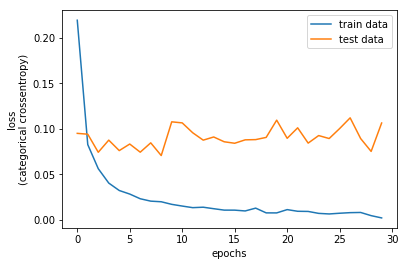

In [18]:
plt.plot(epochs, train_loss, label="train data")
plt.plot(epochs, test_loss, label="test data")
plt.xlabel("epochs")
plt.ylabel("loss\n(categorical crossentropy)")
plt.legend(loc="upper right")
plt.show()

**損失関数の値**

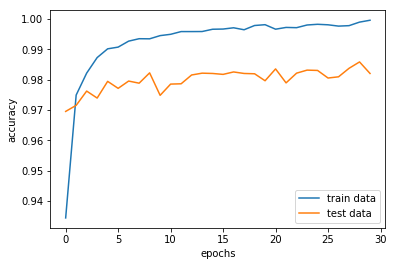

In [19]:
plt.plot(epochs, train_acc, label="train data")
plt.plot(epochs, test_acc, label="test data")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="lower right")
plt.show()

### 7. 学習済みモデルによる推論計算

学習済みモデルを用いて，testデータに対する推論計算を行い，分類結果をみてみましょう．

y_test_pred (i=0):  7
y_test_true (i=0):  7
X_test (i=0): 


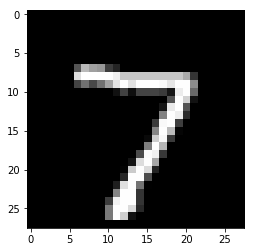

y_test_pred (i=1):  2
y_test_true (i=1):  2
X_test (i=1): 


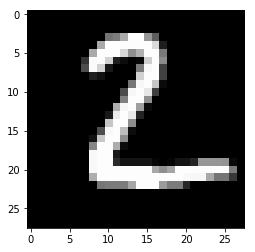

y_test_pred (i=2):  1
y_test_true (i=2):  1
X_test (i=2): 


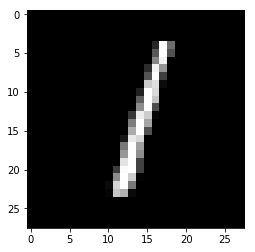

In [20]:
 for i in [0,1,2]:
    y_true = y_test[i]
    y_pred = model.predict_classes(X_test[i].reshape(1,28,28))[0]
    print("y_test_pred", "(i="+str(i)+"): ", y_pred)
    print("y_test_true", "(i="+str(i)+"): ", y_true)
    print("X_test", "(i="+str(i)+"): ")    
    plt.imshow(X_test[i], cmap='gray')
    plt.show()

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


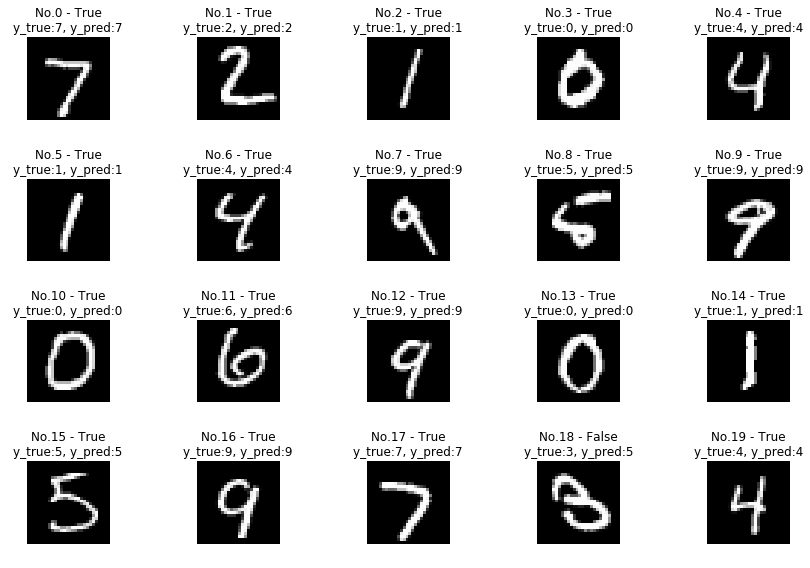

In [21]:
fig = plt.figure(figsize=(12, 8))

ROW = 4
COLUMN = 5

for i in range(ROW * COLUMN):
    y_true = y_test[i]
    y_pred = model.predict_classes(X_test[i].reshape(1,28,28))[0]
    
    if y_true == y_pred:
        result = "True" # Correct answer from the model
    else:
        result = "False" # Incorrect answer from the model
    
    plt.subplot(ROW, COLUMN, i+1)
    plt.imshow(X_test[i], cmap='gray')
    plt.title("No.{} - {}\ny_true:{}, y_pred:{}".format(i, result, y_true, y_pred))
    plt.axis("off")

fig.tight_layout()
fig.show()

### 8. 学習済みモデルの保存

Kerasでは，全てのニューラルネットワークモデルが`keras.models.Model()`クラスのインスタンスとなっています．学習済みモデル`model`に対して，
`model.save()`を実行することで「モデルの保存」が完了します．

> ```python
> # save model as keras instance
> ins_path = 'trained_model_v0.h5'
> model.save(ins_path)
> ```